In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Session 3: Multi-antenna channels and techniques

In the previous sessions, you have learned how to evaluate the performance a user get from a network. To that aim, the channel existing between the user and the base stations have been modelled, this including the path loss, shadowing, and fading.

In this session, multi-antennas networks will be considered. This raises the challenge of i) modelling the MIMO channels, and ii) exploiting the MIMO channel.   

## MIMO channel modelling
Let's first focus on the channel modelling problem, between an emitter equipped with $n_T$ antennas and a receiver with $n_R$ antennas. The channel can be described by a channel matrix $\tilde{\mathbf{H}} \in \mathbb{C}^{n_R \times n_T}$, whose coefficient $\tilde{h}_{ij}$ is the complex channel coefficient between transmitter antenna $i$ and receiver antenna $j$. Such channel coefficient can include the path loss, shadowing, and fading. To begin, the shadowing will not be considered. 

The horizontal distance $d$ between the emitter and the receiver is usually much greater than the dimension of the antenna arrays, and thus the path loss can be considered constant across all antenna pairs. Therefore, the channel model becomes
$$ \tilde{\mathbf{H}} = L(d) \mathbf{H},$$
with $L(d)$ the path loss function. As in the previous sessions, the path loss will be modelled as 
$$ L(d) = \frac{1}{\left(\sqrt{h^2+r^2}\right)^{\alpha}}. $$

Regarding the fading, many random models can be considered to model $\mathbf{H}$. All these models must nevertheless be such that $\mathbb{E}\left[\left|h_{ij}\right|^2\right] =1$ whatever $i$ and $j$, by definition of the fading. In this session, two basic channel models will be considered. 
> **The Rayleigh i.i.d. channel model**: each entry $h_{ij}$ is modelled as a unit-variance complex normal random variable, independent from the other coefficients. 

> **The fully correlated Rayleigh model**: All $h_{ij}$ are equal to the same coefficient $h$, with $h$ being a unit-variance complex normal random variable.

To begin this session, implement i) the path loss model function, ii) the MIMO i.i.d. channel model, and iii) the MIMO fully correlated channel model. 

In [2]:
#Path loss model
def path_loss_model(
    r: np.ndarray, h: float = 1.0, alpha: float = 3.0
) -> np.ndarray:
    """
    Returns the path loss at a distance r from the BS, with a height h, and with a path loss exponent alpha.
    """
    L = (h**2 + r**2) ** (-alpha / 2)
    return L

In [3]:
def MIMO_channel_iid(n_T: int, n_R: int) -> np.matrix:
    """
    Returns the fading channel matrix between a transmitter equipped with n_T antennas and a receiver equipped with n_R antennas,
    with a Rayleigh i.i.d. channel model
    """
    
    Channel_mat =(np.random.randn(n_R,n_T)+1j * np.random.randn(n_R,n_T))/np.sqrt(2) #divided by sqrt of 2 fatcor to have a unit variance
    
    return np.matrix(Channel_mat) 

In [4]:
def MIMO_channel_full_cor(n_T: int, n_R: int) -> np.matrix:
    """
    Returns the fading channel matrix between a transmitter equipped with n_T antennas and a receiver equipped with n_R antennas,
    with a fully correlated Rayleigh channel model
    """
    
    h = (np.random.randn()+1j * np.random.randn())/np.sqrt(2)
    Channel_mat = h * np.ones((n_R,n_T))
    return np.matrix(Channel_mat)

It is important to ensure the channel matrix elements have correctly be normalised to have a in average a unit power gain. Implement in the below cell a test proving this.

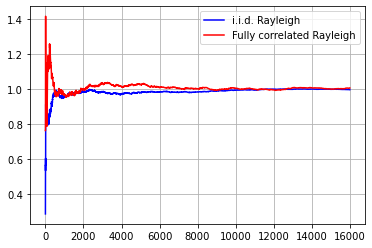

In [5]:
#Check that the Rayleigh variables have been correctly normalised.
N_draw = 4000
n_T = 2
n_R = 2
realisations_iid = np.zeros(N_draw*n_T*n_R)
realisations_full_cor = np.zeros(N_draw*n_T*n_R)

for n in range(N_draw):
    channel_iid = MIMO_channel_iid(n_T, n_R)
    realisations_iid[n*n_T*n_R:(n+1)*n_T*n_R] = np.ndarray.flatten(np.square(np.abs(channel_iid)))
    
    channel_full_cor = MIMO_channel_full_cor(n_T, n_R)
    realisations_full_cor[n*n_T*n_R:(n+1)*n_T*n_R] = np.ndarray.flatten(np.square(np.abs(channel_full_cor)))
    
#Draw how the average converges to 1
increasing_av_iid = np.cumsum(realisations_iid)/np.arange(1,N_draw*n_T*n_R+1)
increasing_av_full_cor = np.cumsum(realisations_full_cor)/np.arange(1,N_draw*n_T*n_R+1)
plt.figure()
plt.plot(increasing_av_iid,'b',label = 'i.i.d. Rayleigh')
plt.plot(increasing_av_full_cor,'r',label = 'Fully correlated Rayleigh')
plt.grid()
plt.legend()

To conclude this first part of the session, it should be emphasised that between the two extreme cases of i.i.d. entries, and fully correlated entries, many models exist. Some of these models have been covered during the lecture. 

## MIMO techniques

Thanks to the use of multiple antennas and the emitter, and the receiver, the communication can be improved. Two mains direction can be considered for such improvement. Either a unique communication stream is considered between one emitter and one receiver, and the multiple antennes enable to improve the S(i)NR of the transmission. This is what will be named the **beamforming** techniques. When both the emitter and the receiver are equipped with multiple antennas, then it is also possible to send multiple communication streams simultaneously, on the different antennas. This process is named **multiplexing**. In this session, only the beamforming techniques will be considered. 

In beamforming techniques, mathematically, in order to transmit the signal $x(t)$, an amplitude and a phase shift are applied for each of the antennas. These complex coefficients are grouped into the vector $\mathbf{w}_T \in \mathbb{C}^{n_T\times 1}$, and the transmitted signals read thus as $\mathbf{x}_{T}(t) = \mathbf{w}_Tx(t)$. At the receiver antennas, the signal is obtained as $\mathbf{x}_{R}(t) = \tilde{\mathbf{H}}\mathbf{x}_{T}(t) + \mathbf{n}(t)  = \tilde{\mathbf{H}}\mathbf{w}_Tx(t) + \mathbf{n}(t)$, with $\mathbf{n}(t)$ the noise vector whose elements are almost always assumed to be i.i.d. AWGN noises. Then, a beamforming vector $\mathbf{w}_R \in \mathbb{C}^{1 \times n_R}$ is applied, in order to obtain $y(t) = \mathbf{w}_R\mathbf{x}_{R}(t)$, leading to 
$$y(t)  = \mathbf{w}_R\tilde{\mathbf{H}}\mathbf{w}_Tx(t) + \mathbf{w}_R\mathbf{n}(t).$$ 

Based on this expression, the signal power is obtained as 
$$P_s = \left|\mathbf{w}_R\tilde{\mathbf{H}}\mathbf{w}_T\right|^2 P_0,$$
and the noise power as
$$ P_N = \|\mathbf{w}_R\|^2_2 \sigma^2_n,$$
with $P_0$ and $\sigma^2_n$ the signal and noise powers. Note that interference can be computed in a similar way. 

Implement the two below functions, computing these powers based on the beamformers and channel matrix. 

In [6]:
def received_power(path_loss,Channel_mat,w_T,w_R,P_0):
    #Receiver power, based on the path loss, channel matrix, transmit and receive beamformers w_T and w_R, and P_0 the power of signal
    
    Power_coeff_beamforming = np.abs(w_R@Channel_mat@w_T)**2 #power coeffient due to the beamforming
    P_R = P_0 * path_loss * Power_coeff_beamforming
    return P_R

In [7]:
def noise_power(w_R,sigma_sq_n):
    #Noise power after the receiver beamforming
    
    return np.linalg.norm(w_R,2)**2 * sigma_sq_n

As you can observed, the norm of the beamforming vectors impact the transmit and receive power. Hence, for mathematical convenience, such beamforming vectors are assumed to be normalised in order to have a unit norm: $\|\mathbf{w}_T\|^2_2=1$, $\|\mathbf{w}_R\|^2_2=1$.

Such vectors can be designed to optimise the system performance. Several possibilities are presented in the lectures, in the SIMO, MISO and MIMO case. Let us focus first on MISO techniques, and more precisely on the Maximum Ratio Transmission (MRT) technique which optimises the SNR. Implement the below function, providing the transmit beamforming vector based on the channel matrix. 

In [8]:
#Implement MRT beamformer
def MRT(Channel_Mat):
    #Channel_Mat is the vector containing the channel coefficients, it should be of shape 1xn_T
    #return w = h^H/||h||, a n_T \times 1 vector
    
    w = Channel_Mat.H/np.linalg.norm(Channel_Mat,2)
    return w

## Monte-Carlo analysis of the received power 

Now that the MIMO channel models have been presented, and that the beamforming techniques have been implemented, the performance of a user can be evaluated with Monte-Carlo methods.

To begin, we are interested in the received power a single-antenna user get from the BS, when this latter has $n_T$ antennas and performs a MRT beamforming.

Implement the two below functions, the first one drawing a geometry draw from a PPP, and the second one getting the realisations of the received power. 

In [9]:
# TODO: Implement this function
def sample_PPP(lam: float = 0.03, L: float = 10.0) -> np.ndarray:
    """
    Samples points in a square of side L, using a PPP with parameter lam.
    """
    points = np.random.rand(10, 2)  # Change me
    # :START-REMOVE:
    N = np.random.poisson(lam * L**2)
    points_init = np.random.rand(N, 2)
    points = (points_init - 0.5) * L
    # :END-REMOVE:
    return points

In [10]:
def draws_power_with_beamforming(
    MIMO_Channel_model,
    lam_BS: float = 0.03,
    P0: float = 10.0,
    h: float = 1.0,
    alpha: float = 3.0,
    N_geo: int = 2000,
    L: float = 30.0,
    n_T: int = 1,
    n_R: int = 1
):
    """
    Computes the average power received by  at typical UE located at (0, 0) over N_geo draws, when the BS performs the beamforming.
    The fading channel is given by the MIMO_Channel_model function.
    """
    power_array = np.zeros((N_geo,))
    # :START-REMOVE:
    for m in range(N_geo):
        points_BS = sample_PPP(lam=lam_BS, L=L)
        distance = np.sqrt((points_BS[:, 0]) ** 2 + (points_BS[:, 1]) ** 2)
        d_min = np.min(distance) #closest BS
        
        path_loss = path_loss_model(d_min, h, alpha)
        Channel_Mat = MIMO_Channel_model(n_T, n_R)
        w_T = MRT(Channel_Mat)
        w_R = np.array([[1]])
        power_array[m] = received_power(path_loss,Channel_Mat,w_T,w_R,P0)
        
    # :END-REMOVE:
    return power_array

Draw samples of the received powers, considering the i.i.d. channel model and the fully correlated one. Conider BS densities ranging from $\lambda_{\text{BS}} = 0.004,..., 0.4$, and number of antennas $n_T = 1,2,5,20$.  

In [50]:
MRT_results_iid = []
MRT_results_full_cor = []

# :START-REMOVE:
alpha = 3.0
N_geo = 2000
P0 = 10
h = 1
L = 100
lambda_vec = np.linspace(0.004, 0.4, 100)
N_lam = len(lambda_vec)
N_T_vec = np.array([1,2,5,20])

for n_T in N_T_vec:
    row_iid = np.zeros((N_geo,N_lam))
    row_full_cor = np.zeros((N_geo,N_lam))
    for n in range(N_lam):
        lam = lambda_vec[n]
        row_iid[:,n]  = draws_power_with_beamforming(
                MIMO_channel_iid,
                lam_BS= lam,
                P0 = P0,
                h = h,
                alpha = alpha,
                N_geo = N_geo,
                L = L,
                n_T = n_T,
                n_R =1,
            )
        
        row_full_cor[:,n] = draws_power_with_beamforming(
                MIMO_channel_full_cor,
                lam_BS= lam,
                P0 = P0,
                h = h,
                alpha = alpha,
                N_geo = N_geo,
                L = L,
                n_T = n_T,
                n_R =1,
            )
        

    MRT_results_iid.append(row_iid)
    MRT_results_full_cor.append(row_full_cor)
# :END-REMOVE:

Based on the above draws, compare the averaged received powers as a function of the BS densities, for the various number of antennas and the two channel model. Are you able to observe the array gain, and the diversity gain? 

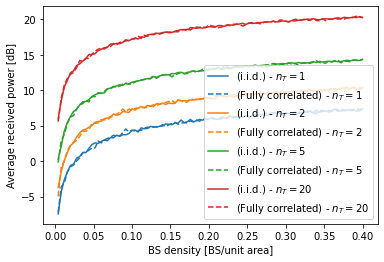

In [51]:
# TODO: Complete this cell accordingly

plt.figure()
# Square results
for i, n_T in enumerate(N_T_vec):
    line, = plt.plot(
        lambda_vec,
        10 * np.log10(np.mean(MRT_results_iid[i],axis = 0)),
        "-",
        label=f"(i.i.d.) - $n_T = {n_T}$",
    )
    plt.plot(
        lambda_vec,
        10 * np.log10(np.mean(MRT_results_full_cor[i],axis = 0)),
        color = line.get_color(), linestyle = '--',
        label=f"(Fully correlated) - $n_T = {n_T}$",
    )

plt.legend()
plt.xlabel("BS density [BS/unit area]")
plt.ylabel("Average received power [dB]");
# :END-REMOVE:

Not only the average power matters, but the power distribution is also important. Based on the above draws, draw the CCDF of the received power, for the various number of antennas and the two channel models. Are you able to observe the array gain, and the diversity gain? You can consider any BS density $\lambda_{\text{BS}}$. 

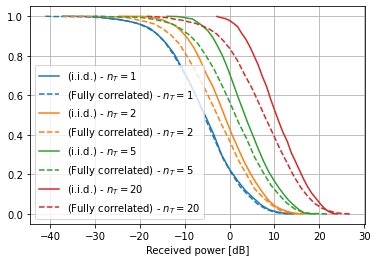

In [62]:
n_bins = 30
idx_lam = 10

for i, n_T in enumerate(N_T_vec):
    #i.i.d. channel
    powers_ppp = MRT_results_iid[i][:,idx_lam]
    hist_ppp, bin_edges_ppp = np.histogram(
        10 * np.log10(powers_ppp), bins=n_bins, density=True
    )
    CDF_ppp = np.cumsum(hist_ppp * np.diff(bin_edges_ppp))
    CCDF_ppp = 1 - CDF_ppp
    line, = plt.plot(bin_edges_ppp[:-1], CCDF_ppp, "-", label=f"(i.i.d.) - $n_T = {n_T}$")
    
    #fully correlated channel
    powers_ppp = MRT_results_full_cor[i][:,idx_lam]
    hist_ppp, bin_edges_ppp = np.histogram(
        10 * np.log10(powers_ppp), bins=n_bins, density=True
    )
    CDF_ppp = np.cumsum(hist_ppp * np.diff(bin_edges_ppp))
    CCDF_ppp = 1 - CDF_ppp
    line, = plt.plot(bin_edges_ppp[:-1], CCDF_ppp, color = line.get_color(), linestyle = "--", label=f"(Fully correlated) - $n_T = {n_T}$")
    
    
plt.legend()


plt.xlabel("Received power [dB]")
plt.grid()


## Monte-Carlo analysis of the SINR

The received power, in itself, is not sufficient to characterise the communication quality. One can instead assess the SINR of the user. 

To that aim, one must evaluate the power received from the other BS, which also beamform towards another user. One possibility to do so would be to consider two PPPs (one for the BS and one for the users), to associate the users with the BSs and them to compute the MRT beamforming vector for each BS. Yes, problems arise as some BSs can be associated with no user, and some might have several users to serve. 

As anyway the users locations are uniform, an alternative way to evaluate the interference is consider only one PPP for the BSs. The BS closest to the origin performs MRT beamformin towards the user located at the origin. It is assumed all other BS serves a unique user. Since the beamforming only depends on the fading channel matrix between the BS and the user it serves, such channel matrix can be draw randomly and the beamforming vectors of all BS can be computed. Then, the interference can be evaluated. 

In [72]:
#Interference computation
# TODO: Implement this function
def draws_interference_with_beamforming(
    MIMO_Channel_model,
    lam_BS: float = 0.03,
    P0: float = 10.0,
    h: float = 1.0,
    alpha: float = 3.0,
    N_geo: int = 2000,
    L: float = 30.0,
    n_T: int = 1,
    n_R: int = 1,
    sigma_sq_n: float = 1.0
):
    """
    Computes the average interference received by  at typical UE located at (0, 0) over N_geo draws. 
    """
    SINR_array = np.zeros((N_geo,))
    # :START-REMOVE:
    for m in range(N_geo):
        points_BS = sample_PPP(lam=lam_BS, L=L)
        N_BS = len(points_BS)
        distance = np.sqrt((points_BS[:, 0]) ** 2 + (points_BS[:, 1]) ** 2)
        i_closest = np.argmin(distance) #closest BS
        
        P_int = 0
        #for each BS, draw a random channel matrix, implement MRT, and compute power
        for n in range(N_BS):
            if n != i_closest:
                Channel_Mat_other_user = MIMO_Channel_model(n_T, n_R)
                w_T_other_user = MRT(Channel_Mat_other_user)
                Channel_Mat_typical_user = MIMO_Channel_model(n_T, n_R) #between interfering BS and typical user
                path_loss_typical_user = path_loss_model(distance[n], h, alpha)
                P_int += received_power(path_loss_typical_user,Channel_Mat_typical_user,w_T_other_user,np.array([[1]]),P0)
        
        #useful link
        Channel_use = MIMO_Channel_model(n_T, n_R)
        w_T_use = MRT(Channel_use)
        path_loss_use = path_loss_model(distance[i_closest], h, alpha)
        P_use = received_power(path_loss_use,Channel_use,w_T_use,np.array([[1]]),P0)  
        
        SINR_array[m] = P_use/(P_int + sigma_sq_n)
    # :END-REMOVE:
    return SINR_array


In [79]:
# power distribution

MRT_results_SINR = []
alpha = 3.0
N_geo = 100
P0 = 10
h = 1
L = 100
lam = 0.04
N_T_vec = np.array([1,2,5,20])
sigma_sq_n = 0.02
for n_T in N_T_vec:
    row = draws_interference_with_beamforming(
                MIMO_channel_iid,
                lam_BS= lam,
                P0 = P0,
                h = h,
                alpha = alpha,
                N_geo = N_geo,
                L = L,
                n_T = n_T,
                n_R =1,
                sigma_sq_n = sigma_sq_n
            )

    MRT_results_SINR.append(row)

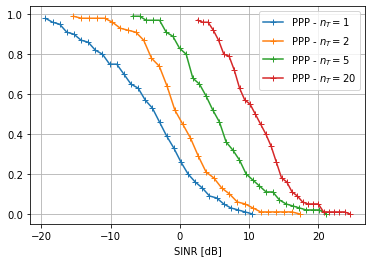

In [80]:
n_bins = 30
for i, n_T in enumerate(N_T_vec):
    powers_ppp = MRT_results_SINR[i]
    hist_ppp, bin_edges_ppp = np.histogram(
        10 * np.log10(powers_ppp), bins=n_bins, density=True
    )
    CDF_ppp = np.cumsum(hist_ppp * np.diff(bin_edges_ppp))
    CCDF_ppp = 1 - CDF_ppp
    plt.plot(bin_edges_ppp[:-1], CCDF_ppp, "+-", label=f"PPP - $n_T = {n_T}$")
plt.legend()


plt.xlabel("SINR [dB]")
plt.grid()
